<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/real_data_drift_test_0918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Default Prediction - Neural Network

https://www.kaggle.com/errearanhas/default-prediction-neural-network-99-acc

##Introduction

Using historical data on loans from Lendig Club - including information on whether or not the borrower defaulted (charge-off) - the main objective of this notebook will be to predict if a potential borrower is likely to pay back the loan.

After explore and pre-process data, we are going to train a Neural Network binary classification model in order to achive this objective. Finally, we evaluate model performance and simulate its operation with a new customer prediction.

Notebook sections:

1. Import data
2. Exploratory Data Analysis
3. Pre-processing
4. Define and train Model
5. Evaluate Model

p.s. work inspired by the excellent Tf2 and Keras DL Bootcamp

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

     |████████████████████████████████| 356 kB 6.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491653 sha256=e12424bb5acaedd4c2a70b4a523531dfa419610b3b2448cc3b2985ca37c6fcfc
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 207 kB 7.3 MB/s 
     |████████████████████████████████| 454.4 MB 9.4 kB/s 
     |████████████████████████████████| 4.8 MB 58.1 MB/s 
     |████████████████████████████████| 2.8 MB 57.2 MB/s 
     |████████████████████████████████| 462 kB 60.2 MB/s 
     |████████████████████████████████| 4.0 MB 64.6 MB/s 
     |████████████████████████████████| 1.2 MB 60.4 MB/s 
     |████████████████████████████████| 895 kB 59.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.8 MB/s 
     |████████████████████████████████| 636 kB 39.5 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
  Attempting unin

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260701, 151)


##Exploratory Data Analysis (and some initial pre-processing)

Since we are going to predict loan_status, let's take a brief closer look on it:

In [5]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

In [6]:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


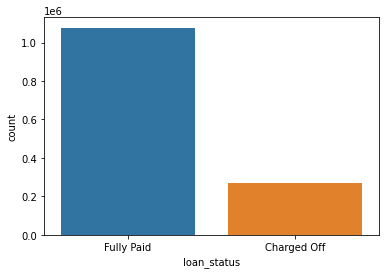

In [7]:
sns.countplot(x="loan_status", data=df_accepted)

checking now null values per columns:

In [8]:
df_accepted.isnull().sum().sort_values(ascending=False)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
hardship_flag                                       0
fico_range_high                                     0
id                                                  0
Length: 151, dtype: int64

wow, there is a bunch of columns almost full of missing values. Let's check the first 50 columns sorted by missing values:

In [9]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_length                               1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_last_payment_amount                  1339556
hardship_payoff_balance_amount                1339556
hardship_amount                               1339556
hardship_status                               1339556
hardship_reason                               1339556
hardship_type                                 1339556
deferral_term                                 1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

let's drop these columns, as it will not contribute to our goal.

In [10]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

let's check again:

In [11]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

open_il_24m                   807712
inq_fi                        807712
open_rv_24m                   807712
open_rv_12m                   807712
open_act_il                   807712
max_bal_bc                    807712
total_bal_il                  807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
mo_sin_rcnt_rev_tl_op          67528
mo_sin_rcnt_tl                 67527
num_accts_ever_120_pd          67527
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_bc_tl                      67527
num_tl_op_past_12m             67527
num_tl_90g_dpd_24m             67527
total_il_high_credit_limit     67527
tot_coll_amt                   67527
t

maybe we can go further, and eliminate columns up to title:

In [12]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [13]:
print(df_accepted['issue_d'])

0          Dec-2015
1          Dec-2015
2          Dec-2015
4          Dec-2015
5          Dec-2015
             ...   
2260688    Oct-2016
2260690    Oct-2016
2260691    Oct-2016
2260692    Oct-2016
2260697    Oct-2016
Name: issue_d, Length: 1345310, dtype: object


for the remaining columns with missing values, let's see the missing percentage:

In [14]:
nulls = df_accepted.isnull().sum().sort_values(ascending=False)
nulls_percentage = (nulls/df_accepted.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
collections_12_mths_ex_med    0.004163
chargeoff_within_12_mths      0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
zip_code                      0.000074
inq_last_6mths                0.000074
issue_d                       0.000000
addr_state                    0.000000
delinq_2yrs                   0.000000
earliest_cr_line              0.000000
purpose                       0.000000
dtype: float64

Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

In [15]:
df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [16]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

let's now take a look at loan_amnt histogram, to have an idea of the amount distribution:

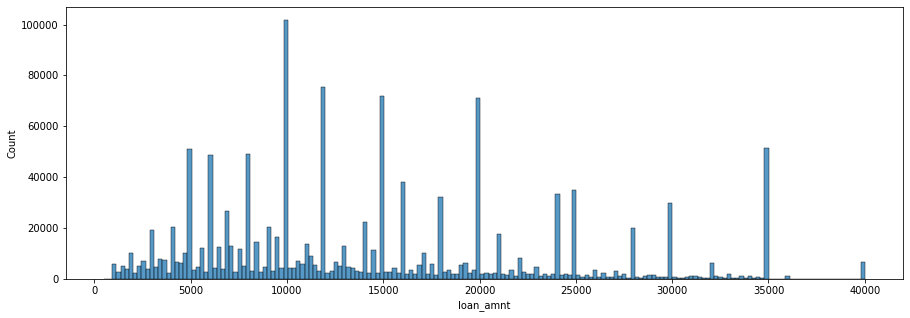

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(df_accepted.loan_amnt, kde=False)

let's now see the correlation between continuous variables:

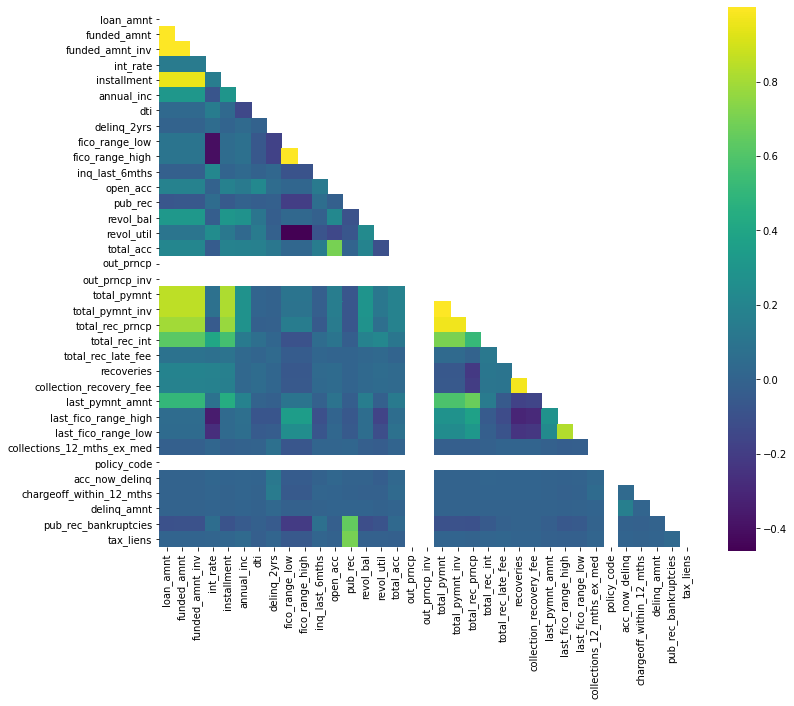

In [18]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

there are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code.

In [19]:
print(df_accepted.out_prncp.value_counts())
print(df_accepted.out_prncp_inv.value_counts())
print(df_accepted.policy_code.value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


These are constant columns. We can drop it either.

In [20]:
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

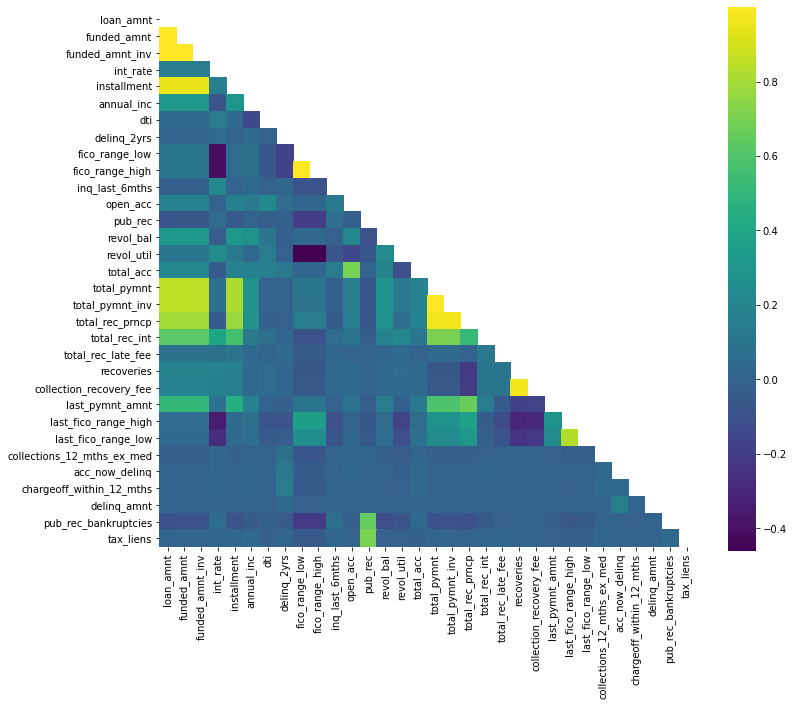

In [21]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

There are many yellowish squares. This indicates almost perfect correlation between many variables. Let's dig deeper:

In [22]:
# unstacking correlation to check highest correlation pairs

c = df_accepted.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']


# check feature pairs above 0.8 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.80)

corr_pairs[cond1 & cond2]

,feature1,feature2,corr
1,fico_range_high,fico_range_low,1.000000
2,loan_amnt,funded_amnt,0.999565
3,total_pymnt,total_pymnt_inv,0.999541
4,funded_amnt_inv,funded_amnt,0.999439
5,loan_amnt,funded_amnt_inv,0.998918
6,collection_recovery_fee,recoveries,0.972674
7,total_rec_prncp,total_pymnt,0.967104
8,total_rec_prncp,total_pymnt_inv,0.966725
9,funded_amnt,installment,0.954037
10,funded_amnt_inv,installment,0.953445


Let's perform scatterplot and visually check some relationships among these features:

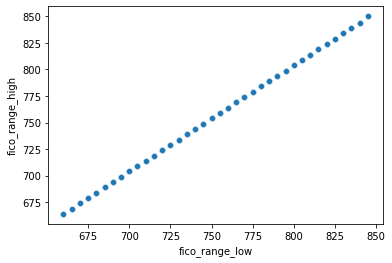

In [23]:
sns.scatterplot(x=df_accepted.fico_range_low, y=df_accepted.fico_range_high)

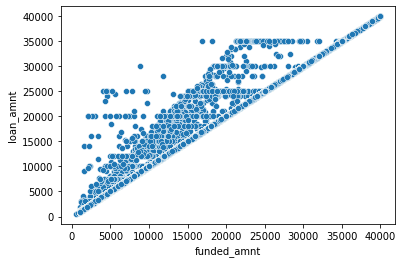

In [24]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.loan_amnt)

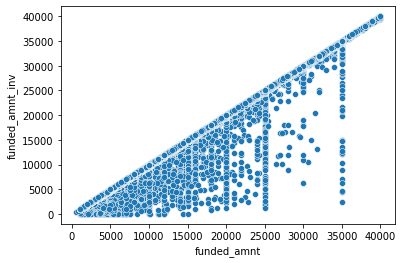

In [25]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.funded_amnt_inv)

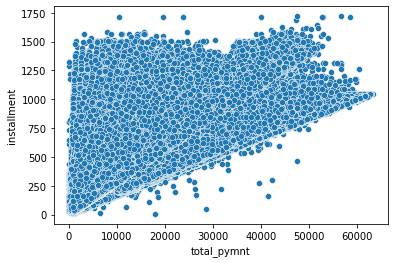

In [26]:
sns.scatterplot(x=df_accepted.total_pymnt, y=df_accepted.installment)

It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

In [27]:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

as our target column is categorical (loan_status), let's create a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [28]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

In [29]:
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

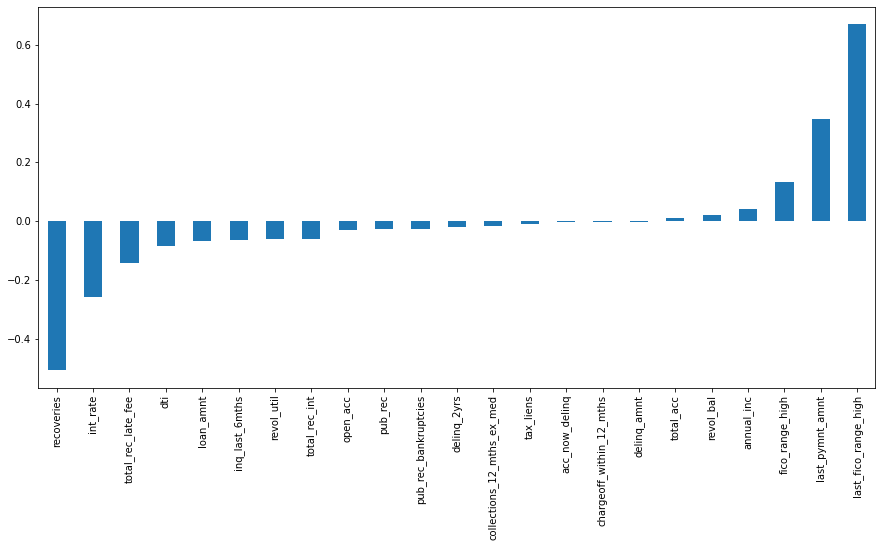

In [30]:
# checking correlation of features to the new loan_paid column


plt.figure(figsize=(15,7))
new_corr = df_accepted.corr().iloc[:-1,-1].sort_values()
new_corr.plot.bar(rot=90)

##Pre-processing

we still have many string categorical columns. Let's work on it:

In [31]:
df_accepted.head()

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,821.72,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,16.06,1.0,Dec-1999,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,979.66,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,10.78,0.0,Aug-2000,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,2705.92,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,0.0,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,25.37,1.0,Jun-1998,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,1340.50,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,10.20,0.0,Oct-1987,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,w,1758.95,0.0,0.0,May-2017,7653.56,May-2017,759.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1


In [32]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)
df_accepted[cat_cols]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


,id,term,grade,sub_grade,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Aug-2018,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Mar-2017,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2018,Mar-2019,Individual,N,Cash,N


In [33]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [34]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


In [35]:
print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [36]:
print(df_accepted.grade.value_counts())
print(df_accepted.sub_grade.value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64
C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


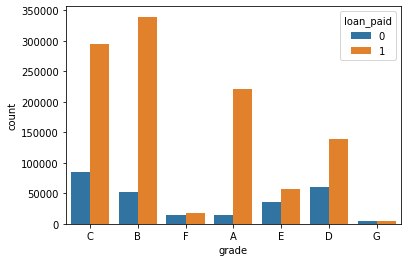

In [37]:
# checking count per grade and loan_paid

sns.countplot(x=df_accepted.grade, hue=df_accepted.loan_paid)

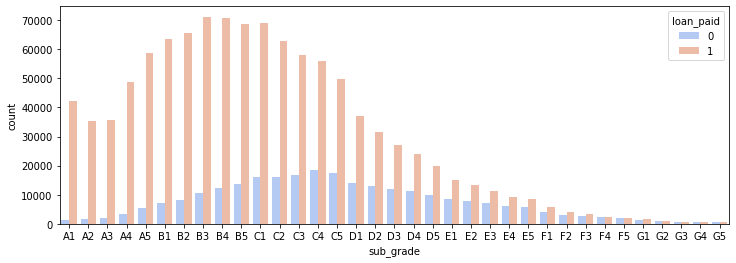

In [38]:
# checking count per subgrade and loan_paid

l = list(df_accepted.sub_grade.unique())
l.sort()

plt.figure(figsize=(12,4))
sns.countplot(x=df_accepted.sub_grade, order=l, hue=df_accepted.loan_paid, palette='coolwarm')

In [39]:
# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

In [40]:
df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

In [41]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


features verification_status, application_type, initial_list_status, purpose

In [42]:
print(df_accepted.verification_status.unique())
print(df_accepted.application_type.unique())
print(df_accepted.initial_list_status.unique())
print(df_accepted.purpose.unique())

['Not Verified' 'Source Verified' 'Verified']
['Individual' 'Joint App']
['w' 'f']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


In [43]:
# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

In [44]:
df_accepted

,loan_amnt,term,int_rate,home_ownership,annual_inc,issue_d,url,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method,debt_settlement_flag,loan_paid,A2,A3,A4,A5,B1,...,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Source Verified,Verified,Joint App,w,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,3600.0,36,13.99,MORTGAGE,55000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,190xx,PA,5.91,0.0,Aug-2003,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,821.72,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,24700.0,36,11.99,MORTGAGE,65000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,577xx,SD,16.06,1.0,Dec-1999,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,979.66,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,20000.0,60,10.78,MORTGAGE,63000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,605xx,IL,10.78,0.0,Aug-2000,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,2705.92,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10400.0,60,22.45,MORTGAGE,104433.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,174xx,PA,25.37,1.0,Jun-1998,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1340.50,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,11950.0,36,13.44,RENT,34000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,300xx,GA,10.20,0.0,Oct-1987,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,1758.95,0.0,0.0,May-2017,7653.56,May-2017,759.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,60,9.49,OWN,130000.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,775xx,TX,20.59,0.0,Jul-2004,739.0,1.0,17.0,0.0,23833.0,34.0,39.0,2756.23,0.0,0.0,Aug-2018,12828.77,Mar-2019,709.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2260690,29400.0,60,13.99,MORTGAGE,180792.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,900xx,CA,22.03,0.0,Mar-2002,709.0,1.0,16.0,0.0,77480.0,85.2,32.0,6448.76,0.0,0.0,Jul-2018,22192.81,Jul-2018,719.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2260691,32000.0,60,14.49,MORTGAGE,157000.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,863xx,AZ,10.34,0.0,Jun-2011,739.0,0.0,14.0,0.0,111598.0,27.4,18.0,1861.47,0.0,0.0,Mar-2017,752.74,Dec-2018,499.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2260692,16000.0,60,12.79,RENT,150000.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,284xx,NC,12.25,0.0,Aug-1997,669.0,0.0,12.0,4.0,7700.0,55.0,28.0,2660.61,0.0,0.0,Mar-2018,12874.54,Mar-2019,684.0,0.0,0.0,0.0,0.0,3.0,0.0,Cash,N,1,

In [45]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'issue_d', 'url', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


feature home_ownership

In [46]:
df_accepted.home_ownership.value_counts()

MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: home_ownership, dtype: int64

In [47]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

features issue_d, url, last_pymnt_d and last_credit_pull_d

--> 여기서는 issue_d column을 drop 했지만... 우리는 이걸 살린다!!!

In [48]:
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])

In [49]:
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])

In [50]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['issue_d', 'earliest_cr_line', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


features disbursement_method and debt_settlement_flag

In [51]:
print(df_accepted.disbursement_method.value_counts())
print(df_accepted.debt_settlement_flag.value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


In [52]:
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

feature earliest_cr_line

In [53]:
print(df_accepted.earliest_cr_line.value_counts())

Aug-2001    9365
Aug-2002    9066
Sep-2003    9000
Oct-2001    8838
Aug-2000    8822
            ... 
Feb-1957       1
Feb-1960       1
Dec-1950       1
Dec-1951       1
Mar-1957       1
Name: earliest_cr_line, Length: 739, dtype: int64


In [54]:
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

In [55]:
df_accepted.shape

(1341026, 83)

In [56]:
df_accepted

,loan_amnt,term,int_rate,annual_inc,issue_d,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,loan_paid,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,...,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Source Verified,Verified,Joint App,w,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,MORTGAGE,OTHER,OWN,RENT,DirectPay,Y
0,3600.0,36,13.99,55000.0,Dec-2015,5.91,0.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,821.72,0.0,0.0,122.67,564.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,24700.0,36,11.99,65000.0,Dec-2015,16.06,1.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,979.66,0.0,0.0,926.35,699.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,20000.0,60,10.78,63000.0,Dec-2015,10.78,0.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,2705.92,0.0,0.0,15813.30,704.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,10400.0,60,22.45,104433.0,Dec-2015,25.37,1.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1340.50,0.0,0.0,10128.96,704.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
5,11950.0,36,13.44,34000.0,Dec-2015,10.20,0.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,1758.95,0.0,0.0,7653.56,759.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,60,9.49,130000.0,Oct-2016,20.59,0.0,739.0,1.0,17.0,0.0,23833.0,34.0,39.0,2756.23,0.0,0.0,12828.77,709.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2260690,29400.0,60,13.99,180792.0,Oct-2016,22.03,0.0,709.0,1.0,16.0,0.0,77480.0,85.2,32.0,6448.76,0.0,0.0,22192.81,719.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2260691,32000.0,60,14.49,157000.0,Oct-2016,10.34,0.0,739.0,0.0,14.0,0.0,111598.0,27.4,18.0,1861.47,0.0,0.0,752.74,499.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2260692,16000.0,60,12.79,150000.0,Oct-2016,12.25,0.0,669.0,0.0,12.0,4.0,7700.0,55.0,28.0,2660.61,0.0,0.0,12874.54,684.0,0.0,0.0,0.0,0.0,3.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


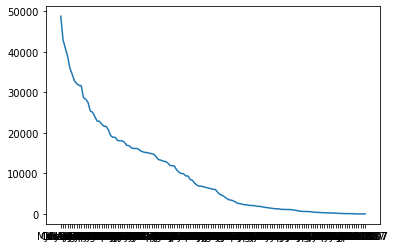

In [57]:
plt.plot(df_accepted['issue_d'].value_counts())

In [58]:
df_accepted[df_accepted['issue_d'].str.endswith('2007') + df_accepted['issue_d'].str.endswith('2008') + df_accepted['issue_d'].str.endswith('2009')]['issue_d'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


Nov-2009    597
Dec-2009    595
Oct-2009    543
Sep-2009    445
Aug-2009    407
Jul-2009    372
Jun-2009    353
May-2009    319
Apr-2009    287
Mar-2009    275
Feb-2009    259
Jan-2009    236
Dec-2008    222
Nov-2008    183
Apr-2008    155
Mar-2008    117
Oct-2008     96
Jul-2008     82
May-2008     69
Aug-2008     69
Jun-2008     66
Sep-2008     32
Feb-2008      7
Jan-2008      6
Dec-2007      2
Nov-2007      2
Oct-2007      1
Name: issue_d, dtype: int64

##Creating a Neural Network Model

now we are ready to start our modelling phase. First, let's apply a train-test-split and scale data before training.

2007,2008,2009 년도 데이터로 학습하고, 이후 각 년도별 Acc를 측정한다.

In [59]:
X = {}
Y = {}

In [60]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.endswith('2007') + df_accepted['issue_d'].str.endswith('2008') + df_accepted['issue_d'].str.endswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [61]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [62]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.endswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


각 년도별 학습

In [63]:
ML = {}
scaler = MinMaxScaler()

In [64]:
for year in range(2009,2019):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.fit_transform(X[year])
    #X_test = scaler.transform(X_test)
    y_train = Y[year]

    # building the model
    print(str(year) + '년도 학습 ======================================')
    ML[year] = Sequential()
    ML[year].add(Dense(units=78,activation='relu'))
    ML[year].add(Dense(units=39,activation='relu'))
    ML[year].add(Dense(units=19,activation='relu'))
    ML[year].add(Dense(units=8,activation='relu'))
    ML[year].add(Dense(units=4,activation='relu'))
    ML[year].add(Dense(units=1,activation='sigmoid'))
    ML[year].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    ML[year].fit(x=X_train, 
            y=y_train, 
            epochs=100,
            batch_size=512,
            verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
            

2009년도 학습 ======================================
Epoch 1/100
12/12 [==============================] - 1s 3ms/step - loss: 0.5735 - accuracy: 0.8496
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4098 - accuracy: 0.8708
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8708
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.8708
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3720 - accuracy: 0.8708
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.8708
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8708
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.8708
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8708
Epoch 10/100
12/12 [==============================] - 0s 3ms

Evaluate model

In [65]:
metric = np.zeros((10,10))
mdf = pd.DataFrame(metric,columns=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'],index=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])


In [66]:
# 2009년 학습으로 2010~2018년까지의 acc 비교
for model_year in range(2009,2019):
    print('model:',model_year)
    for year in range(2009,2019):
        print('test:',year)
        X_test = scaler.fit_transform(X[year])
        predictions = (ML[model_year].predict(X_test) > 0.5).astype("int32")
        acc = accuracy_score(Y[year], predictions)
        print('acc:',acc)
        mdf.iloc[year-2009,model_year-2009] = acc

mdf

model: 2009
test: 2009
acc: 0.9872347766085906
test: 2010
acc: 0.8262155344872576
test: 2011
acc: 0.8774625144175318
test: 2012
acc: 0.8464701464513706
test: 2013
acc: 0.8341850756911741
test: 2014
acc: 0.8427982874222474
test: 2015
acc: 0.853383739282515
test: 2016
acc: 0.8501599138004755
test: 2017
acc: 0.8982757903864772
test: 2018
acc: 0.9063169453995571
model: 2010
test: 2009
acc: 0.9085734000345006
test: 2010
acc: 0.9876489519004957
test: 2011
acc: 0.937762399077278
test: 2012
acc: 0.9151708599324071
test: 2013
acc: 0.859885906139973
test: 2014
acc: 0.8092288912225902
test: 2015
acc: 0.7688702384507102
test: 2016
acc: 0.7002822008243684
test: 2017
acc: 0.7951736385396188
test: 2018
acc: 0.8004104484329151
model: 2011
test: 2009
acc: 0.9220286355011212
test: 2010
acc: 0.944159345916326
test: 2011
acc: 0.9871280276816609
test: 2012
acc: 0.9596695456252347
test: 2013
acc: 0.9567988352918455
test: 2014
acc: 0.9514365726903089
test: 2015
acc: 0.9435865716845113
test: 2016
acc: 0.94141

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
2009,0.987235,0.908573,0.922029,0.934449,0.941521,0.940486,0.933414,0.912196,0.751941,0.687942
2010,0.826216,0.987649,0.944159,0.953031,0.960859,0.966339,0.866400,0.611377,0.675481,0.542402
2011,0.877463,0.937762,0.987128,0.960507,0.968351,0.968443,0.889412,0.734302,0.755479,0.602584
2012,0.846470,0.915171,0.959670,0.985205,0.978276,0.977413,0.871649,0.668551,0.735355,0.568776
2013,0.834185,0.859886,0.956799,0.972212,0.985293,0.982321,0.879139,0.669002,0.772889,0.608114
2014,0.842798,0.809229,0.951437,0.966812,0.977439,0.992514,0.877288,0.741031,0.813259,0.660604
2015,0.853384,0.768870,0.943587,0.959535,0.971337,0.978189,0.991911,0.951929,0.938681,0.906486
2016,0.850160,0.700282,0.941419,0.949153,0.931707,0.948568,0.945209,0.993501,0.966091,0.956979
2017,0.898276,0.795174,0.949361,0.946890,0.916664,0.936520,0.940778,0.988454,0.996187,0.978179
2018,0.906317,0.800410,0.945382,0.940233,0.916218,0.939639,0.944157,0.986462,0.987254,0.995553


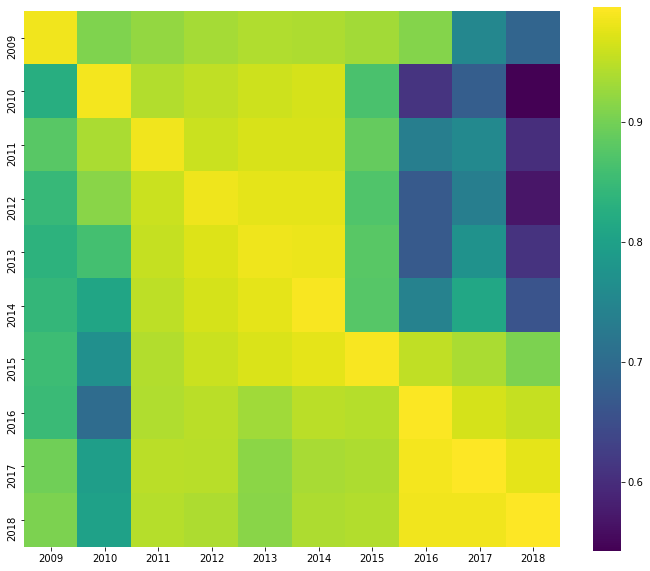

In [67]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(mdf)
mask[np.triu_indices_from(mask)] = False
sns.heatmap(mdf, cmap='viridis', mask=mask, annot=False, square=True)

In [68]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift

In [93]:
# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text

model = ML[2009]
X_test = scaler.fit_transform(X[2009])
y_test = Y[2009]

# ##### EXPLANATIONS #####
print()
print("Generating explanations...")

x_columns = df.loc[:, df.columns != 'loan_paid'].columns

exp = lime_tabular.LimeTabularExplainer(
    X_test,
    training_labels=y_test,
    feature_names=x_columns
) 


Generating explanations...


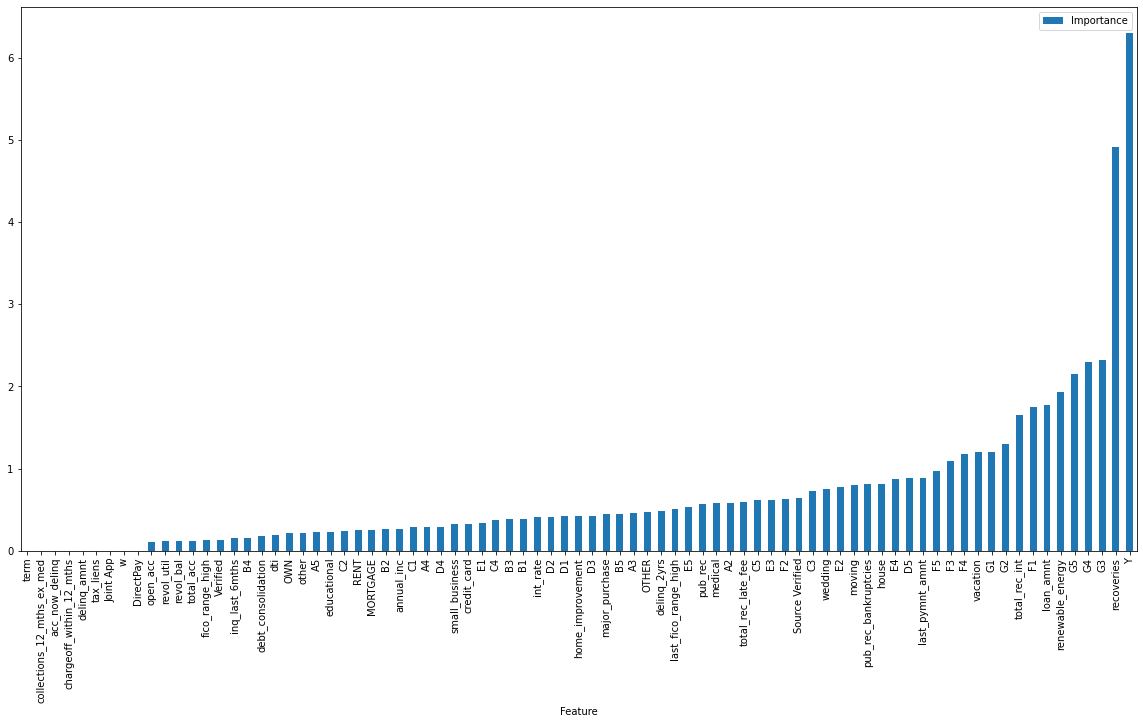

,Feature,Importance
0,term,0.000000
1,collections_12_mths_ex_med,0.000000
2,acc_now_delinq,0.000000
3,chargeoff_within_12_mths,0.000000
4,delinq_amnt,0.000000
...,...,...
76,G5,2.156070
77,G4,2.300725
78,G3,2.318588
79,recoveries,4.912056


In [108]:
import operator
import warnings
warnings.filterwarnings('ignore')

# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in x_columns:
  exp_ana[k] = 0

def predict(data):
    return (model.predict(data) > 0.5).astype("int32")

for x in X_test[0:10]:
    p = exp.explain_instance(x, predict, num_features=len(x_columns),labels=(0,))
    for t in p.as_map()[0]:
        exp_ana[x_columns[t[0]]] += np.abs(t[1])

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Importance'])
effect_result_table['Importance'] = effect_result_table['Importance']
effect_result_table.plot(x='Feature',y='Importance',kind='bar',figsize=(20,10))
plt.show()
effect_result_table

81